# Miniproject: Landing on the Moon

## Introduction

### Description

Traditionally, reinforcement learning has operated on "tabular" state spaces, e.g. "State 1", "State 2", "State 3" etc. However, many important and interesting reinforcement learning problems (like moving robot arms or playing Atari games) are based on either continuous or very high-dimensional state spaces (like robot joint angles or pixels). Deep neural networks constitute one method for learning a value function or policy from continuous and high-dimensional observations. 

In this miniproject, you will teach an agent to play the Lunar Lander game from [OpenAI Gym](https://gym.openai.com/envs/LunarLander-v2/). The agent needs to learn how to land a lunar module safely on the surface of the moon. The state space is 8-dimensional and (mostly) continuous, consisting of the X and Y coordinates, the X and Y velocity, the angle, and the angular velocity of the lander, and two booleans indicating whether the left and right leg of the lander have landed on the moon.

The agent gets a reward of +100 for landing safely and -100 for crashing. In addition, it receives "shaping" rewards at every step. It receives positive rewards for moving closer to [0,0], decreasing in velocity, shifting to an upright angle and touching the lander legs on the moon. It receives negative rewards for moving away from the landing site, increasing in velocity, turning sideways, taking the lander legs off the moon and for using fuel (firing the thrusters). The best score an agent can achieve in an episode is about +250.

There are two versions of the task: one with discrete controls and one with continuous controls but we'll only work with the discrete version. In the discrete version, the agent can take one of four actions at each time step: [do nothing, fire engines left, fire engines right, fire engines down]. 

We will use Policy Gradient approaches (using the REINFORCE rule) to learn the task. As you remember, in standard supervised learning tasks (e.g. image classification), the network generates a probability distribution over the outputs, and is trained to maximize the probability of a specific target output given an observation (input). In Policy Gradient methods, the network generates a probability distribution over actions, and is trained to maximize expected future rewards given an observation.

### Questions
**Question 1**. Suppose that you are designing the environment rewards yourself. Why do you think it is a good idea to have rewards in addition to the +100 reward for safe landing (e.g. for moving closer / further from [0, 0], for touching the lander legs on the moon)? One might say that if we only have a final reward, the agent will still be able to learn how to reach it. What will be the problem here?

**Answer**: First of all, with only a final reward for correctly landing, there would be no time optimization, i.e. the satellite might fly around unnecessarely (do loopings, goes back and forth, ... thus do any kind of expensive move in real applications). Furthermore, the satellite would not be encouraged to land between the flags.


**Question 2**. Now suppose you decide to give the agent a small reward if it moves closer to the landing point but you forget to penalize it when it moves away from it. What kinds of strange behaviour you may observe from the trained agent?

**Answer**: The optimal behavior for the satellite would be to approach the goal (the point [0,0]) and then drifting away from it an infinite number of times. Thus the more we train the model, the more we observe simulations which tend to this behavior, being stopped by the value of the `env._max_episode_steps` parameter.


### Prerequisites

- You will need to install [Miniconda](https://docs.conda.io/en/latest/miniconda.html) and run the following commands:

  - conda create -n cs456env python=3.7.2
  - source activate cs456env
  - pip install gym[Box2D]
  - pip install ipykernel
  - pip install tensorflow
  - pip install keras
  - pip install matplotlib
  
- You should know the concepts of "policy", "policy gradient", "REINFORCE", "REINFORCE with baseline". If you want to start and haven't seen these yet in class, read Sutton & Barto (2018) Chapter 13 (13.1-13.4).

### What you will learn

- You will learn how to implement a policy gradient neural network using the REINFORCE algorithm.
- You will learn how to implement baselines, including a learned value network.
- You will learn how to analyze the performance of an RL algorithm.

### Notes 
- Reinforcement learning is noisy! Normally one should average over multiple random seeds with the same parameters to really see the impact of a change to the model, but we won't do this due to time constraints. However, you should be able to see learning over time with every approach. If you don't see any improvement, or very unstable learning, double-check your model and try adjusting the learning rate.

- You may sometimes see `AssertionError: IsLocked() = False` after restarting your code. To fix this, reinitialize the environments by running the Gym Setup code below.

- You will not be marked on the episode movies. Please delete these movies before uploading your code.

### Evaluation criteria

The miniproject is marked out of 18, with a further mark breakdown in each question:
- Exercise 1: 7 points
- Exercise 2: 3 points
- Exercise 3: 3 points
- Exercise 4: 5 points

We may perform random tests of your code but will not rerun the whole notebook.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Your Names

Before you start, please enter your sciper number(s) in the field below; they are used to load the data.

In [2]:
sciper = {'student_1': 269882, 
          'student_2': 333952}
seed = sciper['student_1']+sciper['student_2']

## Setup

### Dependencies and constants

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import logging
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output
from gym.envs.box2d.lunar_lander import heuristic

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Lambda
from keras.optimizers import Adam
from keras import backend as K

np.random.seed(seed)
tf.random.set_seed(seed*2)

### Gym Setup

Here we load the Reinforcement Learning environments from Gym.

We limit each episode to 500 steps so that we can train faster. 

In [4]:
gym.logger.setLevel(logging.ERROR)
discrete_env = gym.make('LunarLander-v2')
discrete_env._max_episode_steps = 500
discrete_env.seed(seed*3)
gym.logger.setLevel(logging.WARN)

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams["animation.html"] = "jshtml"

### Utilities

We include a function that lets you visualize an "episode" (i.e. a series of observations resulting from the actions that the agent took in the environment).

As well, we will use the `Results` class (a wrapper around a python dictionary) to store, save, load and plot your results. You can save your results to disk with `results.save('filename')` and reload them with `Results(filename='filename')`. Use `results.pop(experiment_name)` to delete an old experiment.

In [5]:
def AddValue(output_size, value):
    return Lambda(lambda x: x + value, output_shape=(output_size,))

def render(episode, env):
    
    fig = plt.figure()
    img = plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')

    def animate(i):
        img.set_data(episode[i])
        return img,

    anim = FuncAnimation(fig, animate, frames=len(episode), interval=24, blit=True)
    html = HTML(anim.to_jshtml())
    
    plt.close(fig)
    !rm None0000000.png
    
    return html

class Results(dict):
    
    def __init__(self, *args, **kwargs):
        if 'filename' in kwargs:
            data = np.load(kwargs['filename'])
            super().__init__(data)
        else:
            super().__init__(*args, **kwargs)
        self.new_key = None
        self.plot_keys = None
        self.ylim = None
        
    def __setitem__(self, key, value):
        super().__setitem__(key, value)
        self.new_key = key

    def plot(self, window):
        clear_output(wait=True)
        for key in self:
            #Ensure latest results are plotted on top
            if self.plot_keys is not None and key not in self.plot_keys:
                continue
            elif key == self.new_key:
                continue
            self.plot_smooth(key, window)
        if self.new_key is not None:
            self.plot_smooth(self.new_key, window)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc='lower right')
        if self.ylim is not None:
            plt.ylim(self.ylim)
        plt.show()
        
    def plot_smooth(self, key, window):
        if len(self[key]) == 0:
            plt.plot([], [], label=key)
            return None
        y = np.convolve(self[key], np.ones((window,))/window, mode='valid')
        x = np.linspace(window/2, len(self[key]) - window/2, len(y))
        plt.plot(x, y, label=key)
        
    def save(self, filename='results'):
        np.savez(filename, **self)

### Test runs

To get an idea of how the environment works, we'll plot an episode resulting from random actions at each point in time, and a "perfect" episode using a specially-designed function to land safely within the yellow flags. 

Please remove these plots before submitting the miniproject to reduce the file size.

In [6]:
def run_fixed_episode(env, policy):
    frames = []
    observation = env.reset()
    done = False
    try:
        while not done:
            frames.append(env.render(mode='rgb_array'))
            action = policy(env, observation)
            observation, reward, done, info = env.step(action)
    finally:
        env.close()
    return frames
    
def random_policy(env, observation):
    return env.action_space.sample()

def heuristic_policy(env, observation):
    return heuristic(env.unwrapped, observation)

## Experiment Loop

This is the method we will call to setup an experiment. Reinforcement learning usually operates on an Observe-Decide-Act cycle, as you can see below.

You don't need to add anything here; you will be working directly on the RL agent.

In [38]:
num_episodes = 3000

def run_experiment(experiment_name, 
                   env, 
                   num_episodes, 
                   policy_learning_rate=0.001, 
                   value_learning_rate=0.01, 
                   baseline=None, 
                   entropy_cost=0, 
                   max_ent_cost=0, 
                   num_layers=3):

    #Initiate the learning agent
    agent = RLAgent(n_obs=env.observation_space.shape[0], 
                    action_space=env.action_space,
                    policy_learning_rate=policy_learning_rate, 
                    value_learning_rate=value_learning_rate, 
                    discount=0.99, 
                    baseline=baseline, 
                    entropy_cost=entropy_cost, 
                    max_ent_cost=max_ent_cost,
                    num_layers=num_layers)

    rewards = []
    all_episode_frames = []
    step = 0
    for episode in range(1, num_episodes+1):

        if episode%10==1: print("Episode: ",end='')
        print(str(episode)+' ', end='')
    
        #Update results plot and occasionally store an episode movie
        episode_frames = None
        if episode % 10 == 0:
            results[experiment_name] = np.array(rewards)
            results.plot(10)
        if episode % 500 == 0:
            episode_frames = []
            
        #Reset the environment to a new episode
        observation = env.reset()
        episode_reward = 0

        while True:
        
            if episode_frames is not None:
                episode_frames.append(env.render(mode='rgb_array'))

            # 1. Decide on an action based on the observations
            action = agent.decide(observation)

            # 2. Take action in the environment
            next_observation, reward, done, info = env.step(action)
            episode_reward += reward

            # 3. Store the information returned from the environment for training
            agent.observe(observation, action, reward)

            # 4. When we reach a terminal state ("done"), use the observed episode to train the network
            if done:
                rewards.append(episode_reward)
                if episode_frames is not None:
                    all_episode_frames.append(episode_frames)
                agent.train()
                break

            # Reset for next step
            observation = next_observation
            step += 1
            
    return all_episode_frames, agent

## The Agent

Here we give the outline of a python class that will represent the reinforcement learning agent (along with its decision-making network). We'll modify this class to add additional methods and functionality throughout the course of the miniproject.


In [50]:
class RLAgent(object):
    
    def __init__(self, n_obs, action_space, policy_learning_rate, value_learning_rate, 
                 discount, baseline = None, entropy_cost = 0, max_ent_cost = 0, num_layers=3):

        # We need the state and action dimensions to build the network
        self.n_obs = n_obs  
        self.n_act = action_space.n
        
        self.plr = policy_learning_rate
        self.vlr = value_learning_rate
        self.gamma = discount
        self.entropy_cost = entropy_cost
        self.max_ent_cost = max_ent_cost
        self.num_layers = num_layers    

        self.policy_model = self._build_network()  

        # These lists stores the cumulative observations for this episode
        self.episode_observations, self.episode_actions, self.episode_rewards, self.episode_actions_taken = [], [], [], []

        # dealing with baseline
        self.baseline = baseline 
        if self.baseline=='adaptive': 
            self.value_model = self._build_network(value=True)
            self.episode_exp_rewards = []

    def observe(self, state, action, reward):
        """ This function takes the observations the agent received from the environment and stores them
            in the lists above."""
        self.episode_observations.append(state)
        self.episode_actions.append(action)
        self.episode_rewards.append(reward)

    def decide(self, state):
        """ This function feeds the observed state to the network, which returns a distribution
            over possible actions."""

        # probabilities
        state=state.reshape((1, self.n_obs))
        action_distribution = (self.policy_model(state)[0]).numpy()
        
        # sample from probabilities
        action_taken = np.random.choice(self.n_act,1,p=action_distribution)[0]

        # one-hot encoder
        episode_action_taken = np.zeros(self.n_act)
        episode_action_taken[action_taken] = 1

        # update variables
        self.episode_actions_taken.append(episode_action_taken)

        # expected rewards
        if self.baseline=='adaptive':
            episode_exp_reward = (self.value_model(state)[0][0]).numpy()
            self.episode_exp_rewards.append(episode_exp_reward)
        
        return action_taken

    def train(self):
        """ When this function is called, the accumulated episode observations, actions and discounted rewards
            should be fed into the network and used for training."""

        T = len(self.episode_observations)
        gamma_factor = self.gamma**np.arange(T)
        disc_episode_rewards = np.array(self._get_returns())

        if self.baseline=='simple': 
            delta = disc_episode_rewards - np.mean(disc_episode_rewards)
        elif self.baseline=='adaptive':
            delta = disc_episode_rewards - np.array(self.episode_exp_rewards)
            self.value_model.train_on_batch(np.array(self.episode_observations),
                                            np.vstack(disc_episode_rewards),
                                            sample_weight = gamma_factor)
            self.episode_exp_rewards = []
        else:
            delta = disc_episode_rewards

        # training policy NN (labels : one-hot-encodings vectors (self.episode_actions_taken))
        self.policy_model.train_on_batch(np.array(self.episode_observations),
                                         np.array(self.episode_actions_taken),
                                         sample_weight = delta*gamma_factor)
        
        # reset arrays
        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []
        self.episode_actions_taken = []

    def _get_returns(self):
        """ This function should process self.episode_rewards and return the discounted episode returns
            at each step in the episode."""

        disc_episode_rewards = []
        sum = 0

        for reward in self.episode_rewards[::-1]:      
            sum = sum*self.gamma + reward
            disc_episode_rewards.append(sum)

        return disc_episode_rewards[::-1]

    def _build_network(self, value=False):
        """ This function should build the network that can then be called by decide and train. 
            The network takes observations as inputs and has a policy distribution as output."""
        
        model = Sequential()

        # input layer + hidden layers
        model.add(Dense(16, input_dim=self.n_obs, activation='relu'))
        for _ in range(self.num_layers-1):
            model.add(Dense(16, activation='relu')) 

        # output layer, loss and optimizer, depending on value or policy network
        if value:
            model.add(Dense(1))
            model.compile(loss='mse',optimizer=Adam(learning_rate=self.vlr))
        else:
            model.add(Dense(self.n_act, activation='softmax'))
            model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=self.plr)) # default learning rate so far

        return model

## Exercise 1: REINFORCE with simple baseline

### Description

Implement the REINFORCE Policy Gradient algorithm using a deep neural network as a function approximator.

1. Implement the `observe` method of the RLAgent above.
2. Implement the `_build_network` method. Your network should take the 8-dimensional state space as input and output a softmax distribution over the 4 discrete actions. It should have 3 hidden layers with 16 units each with ReLU activations. Use the REINFORCE loss function. HINT: Keras has a built-in "categorical cross-entropy" loss, and a `sample_weight` argument in fit/train_on_batch. Consider how these could be used together.
3. Implement the `decide`, `train` and `_get_returns` methods using the inputs and outputs of your network. In `train`, implement a baseline based on a moving average (over episodes) of the mean returns (over trials of one episode); it should only be in effect when the agent is constructed with the `use_simple_baseline` keyword. Also, use `train_on_batch` to form one minibatch from all the experiences in an episode. Hint: see Question 2) below.
4. Try a few learning rates and pick the best one (the default for Adam is a good place to start). Run the functions below and include the resulting plots, with and without the baseline, for your chosen learning rate. 
5. Answer the questions below in max. 1-2 sentence(s).

WARNING: Running any experiments with the same names (first argument in run_experiment) will cause your results to be overwritten. 

**Mark breakdown: 7 points total**
- 5 points for implementing and plotting basic REINFORCE with reasonable performance (i.e. a positive score) and answering the questions below.
- 2 points for implementing and plotting the simple baseline with reasonable performance.

### Solution

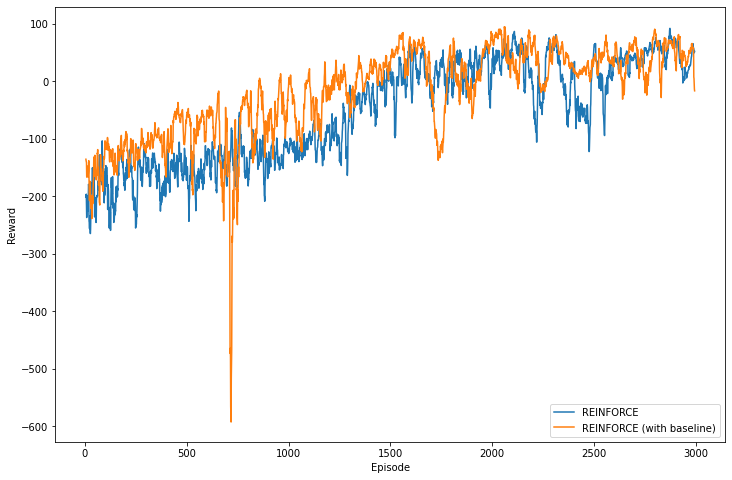

In [40]:
results = Results()
policy_lr = 0.002
_, _ = run_experiment("REINFORCE", discrete_env, num_episodes, policy_learning_rate=policy_lr)
episodes, _ = run_experiment("REINFORCE (with baseline)", discrete_env, num_episodes, policy_learning_rate=policy_lr,
                             baseline='simple')

**REINFORCE**: Focusing on the REINFORCE implementation, we observe that the rewards are increasing as expected. We attain reasonable performances in +- 1500 episodes.\
**REINFORCE (with baseline)**: We observe basically the same behaviour than REINFORCE, i.e. increasing rewards. We also observe that Reinforcement Learning is indeed noisy (especially around 650-700 episodes), but we see that the model is able to rectify itself quite quickly. We also observe that the orange trace is above the blue one for the beginning of the training process, meaning that the models trains itself faster by using the simple baseline.

**Question 1**: We have at least three posibilities of picking the action: i) sample an action according to the softmax distribution, ii) select action with max action probability and iii) use an epsilon-greedy strategy. What is the difference between these strategies and which one(s) is(are) preferable during training and which one(s) is(are) preferable during testing?. 


**Answer**: The first and third possibilities are stochastic strategies while the second one is deterministic. We use stochastic strategies for the training phase since we want to explore other scenarios in order not to get stuck in a non-optimal solution (with a preference for the first strategy, which entirely takes account of the softmax output), and we use deterministic strategies for the testing phase since we do not need to explore more scenarios anymore (we just want to maximize our chance to see the satellite behaves well).

**Question 2**: In the train method above we throw away the data from an episode after we use it to train the network (make sure that you do that). Why is it not a good idea to keep the old episodes and train the policy network on both old and new data? (Note: Reusing data can still be possible but requires modifications to the REINFORCE algorithm that we are using).

**Answer**: If we do that, then the scenarios on which the agent trains itself are composed of jumps from a final state (landing) to an initial state (from the end of one episode to the beginning of another). These jumps are not feasible in the model, resulting in a non-appropriate training, thus doing that would require a different algorithm that the one we are using.

## Exercise 2: Adaptive baseline
### Description

Add a second neural network to your model that learns an observations-dependent adaptive baseline and subtracts it from your discounted returns.

1. Modify the `_build_network` function of RLAgent to create a second "value network" when `adaptive` is passed for the baseline argument. The value network should have the same or similar structure as the policy network, without the softmax at the output.
3. In addition to training your policy network, train the value network on the Mean-Squared Error compared to the discounted returns.
4. Train your policy network on $R - b(s)$, i.e. the returns minus the adaptive baseline (the output of the value network). Your implementation should allow for a different learning rate for the value and policy network.
5. Try a few learning rates and plot all your best results together (without baseline, with simple baseline, with adaptive baseline). You may or may not be able to improve on the simple baseline! Return the trained model to use it in the next exercise.

TECHNICAL NOTE: Some textbooks may refer to this approach as "Actor-Critic", where the policy network is the "Actor" and the value network is the "Critic". Sutton and Barto (2018) suggest that Actor-Critic only applies when the discounted returns are bootstrapped from the value network output, as you saw in class. This can introduce instability in learning that needs to be addressed with more advanced techniques, so we won't use it for this miniproject. You can read more about state-of-the-art Actor-Critic approaches here: https://arxiv.org/pdf/1602.01783.pdf

**Mark breakdown: 3 points total**
- 3 points for implementing and plotting the adaptive baseline with the other two conditions, with reasonable performance (i.e. at least similar to the performance in Exercise 1).

### Solution

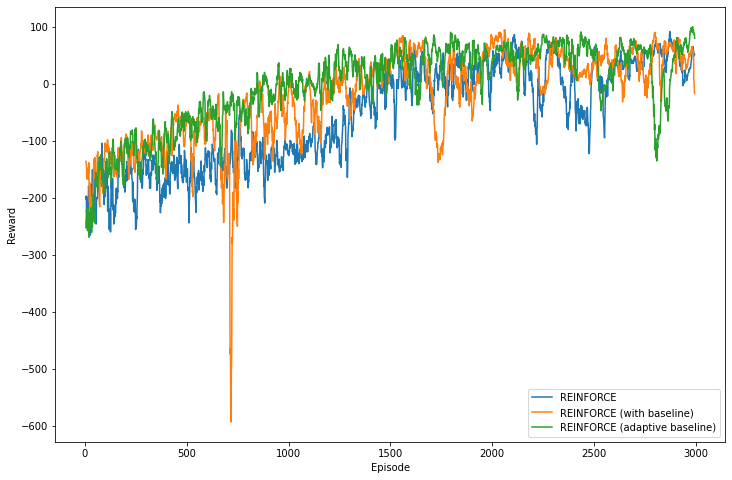

In [45]:
value_lr = 0.02
episodes, d_model = run_experiment("REINFORCE (adaptive baseline)", discrete_env, num_episodes, policy_learning_rate=policy_lr, 
                                   value_learning_rate=value_lr, baseline='adaptive')

**REINFORCE (adaptive baseline)**: We observe an improvement of the performances of Reinforcement Learning when using an adaptive baseline. Indeed, we see that we achieve positive rewards in less than 1000 episodes. Furthermore, we observe that the green trace is above the two others for the first part of the training process (meaning that the model trains itself faster).

## Exercise 3: Visualizing the Value Function

### Description

Ideally, our value network should have learned to predict the relative values across the input space. We can test this by plotting the value prediction for different observations.

1. Write a function to plot the value network prediction across [x,y] space for given (constant) values of the other state variables. X is always in [-1,1], and Y generally lies in [-0.2,1], where the landing pad is at [0,0]. (`plt.imshow`, `plt.title`, and `plt.colorbar` can be useful)
2. Plot (with titles specifying the state variable combinations) the values for 5-6 combinations of the other 6 state variables, including [0,0,0,0,0,0]. The X and Y velocity are generally within [-1,1], the angle is in [-pi,pi] and the angular velocity lies roughly within [-3,3]. The last two inputs indicating whether the legs have touched the ground are 0 (False) or 1 (True). Include two combinations with (one of the) state variables out of these ranges. Use the same color bar limits across the graphs so that they can be compared easily. 
3. Answer the question below in max. 2-3 sentence(s).

**Mark breakdown: 3 points total**
- 3 points for the plots of the value function and answering the question below.

### Solution

In [11]:
def plot_value(d_model, comb, n):
    X = np.linspace(-1,   1, num=n)
    Y = np.linspace(-0.2, 1, num=n)
    value = np.zeros((n,n))
    for i,x in enumerate(X):
        for j,y in enumerate(Y):
            state     = [0]*8
            state[0]  = x
            state[1]  = y
            state[2:] = comb
            value[j,i] = (d_model.value_model(np.array([state]))[0][0]).numpy()
    
    fig = plt.figure()
    plt.imshow(value, cmap='plasma', extent=[-1, 1, -0.2, 1])
    plt.colorbar()
    
    # title
    plt.title(f"Expected reward (other states are {comb})")
    
    # labels
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    
    plt.show()

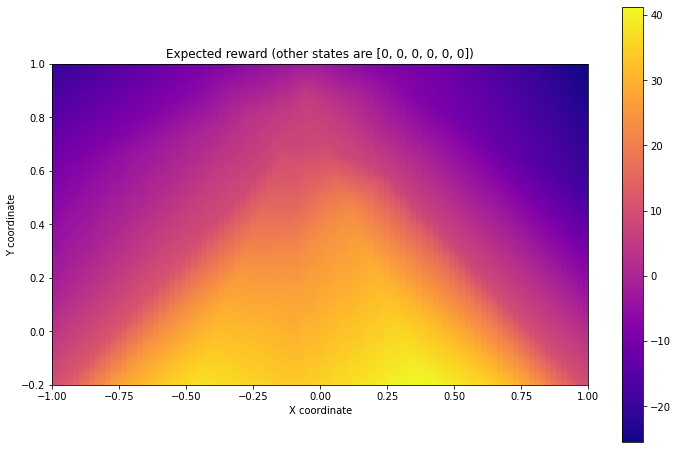

In [12]:
plot_value(d_model, [0,0,0,0,0,0], 100)

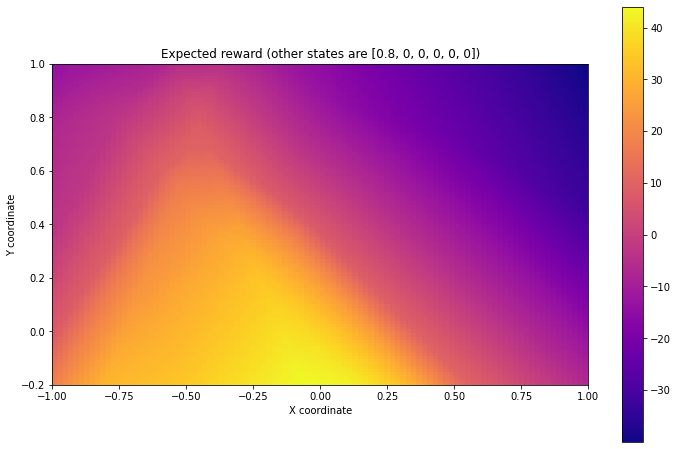

In [30]:
plot_value(d_model, [0.8,0,0,0,0,0], 100)

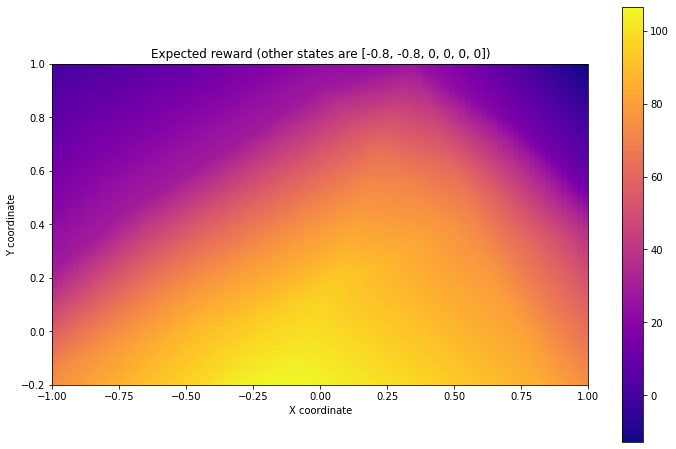

In [29]:
plot_value(d_model, [-0.8,-0.8,0,0,0,0], 100)

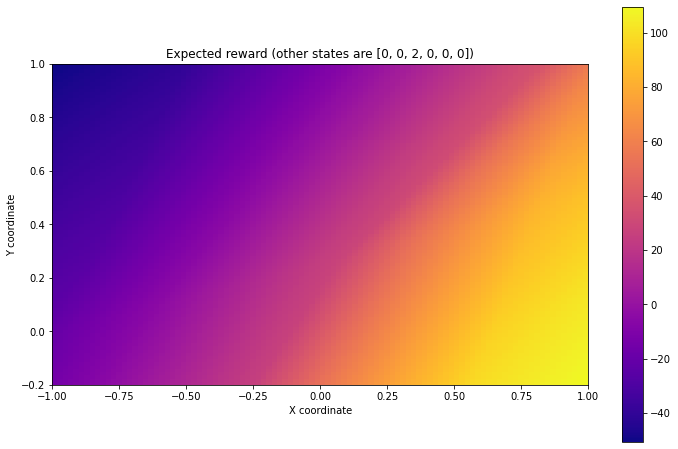

In [24]:
plot_value(d_model, [0,0,2,0,0,0], 100)

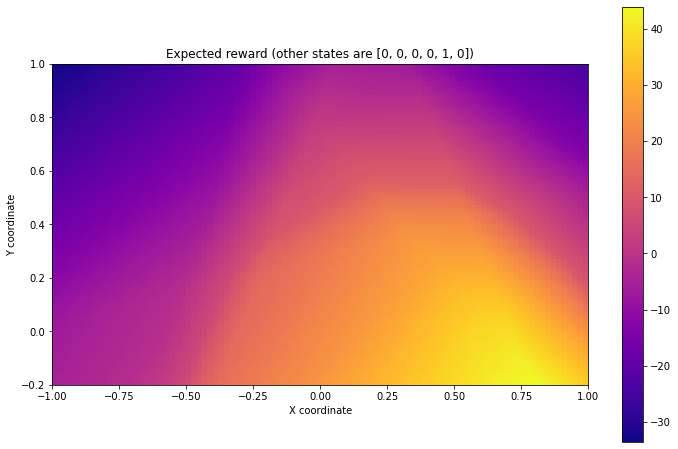

In [17]:
plot_value(d_model, [0,0,0,0,1,0], 100)

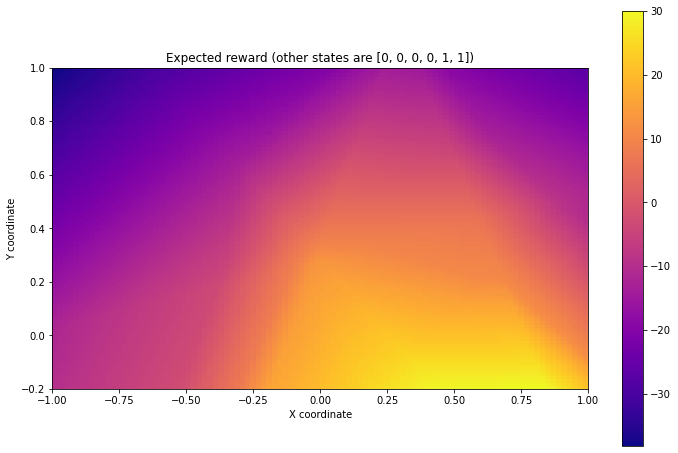

In [26]:
plot_value(d_model, [0,0,0,0,1,1], 100)

**Question**: Does your value map for the state variables combination [0,0,0,0,0,0] make sense? What about the value maps for the combinations with state variables out of the ranges above?

**Answer**: We see that the highest values are at [0,0], which makes sense since we are close the goal (and we want the satellite to approach it). Furthermore, we see that the lowest values are achieved at the upper corners, which also makes sense since the satellite has no interest in being there in order to reach the goal. Thus, the distribution in inverse V shape (which can be properly observed) is the consequence of these two edge cases. 


## Exercise 4: Comparing Architectures
### Description

Choosing a good neural network architecture is always a tricky question - on one hand, you want a complex architecture that is flexible enough to be able to solve the task, and on the other hand, you want to train your network as fast as possible and to not overuse your computational power. In the previous sections, we asked you to create a network with 3 hidden layers which you saw that is able to successfully solve the task and play the game. What happens if we do the same with 1 or 2 hidden layers? In this exercise, we ask you to look into the effect of the architecture and to compare different models with each other.

1. Include an extra parameter `num_layers` in the RLAgent class (by default it is equal to 3).
2. Change the `_build_network` function so that it creates a policy and value networks with the required number of layers.
3. Compare (on the same axes) the resulting plots for num_layers = 1, 2, 3.

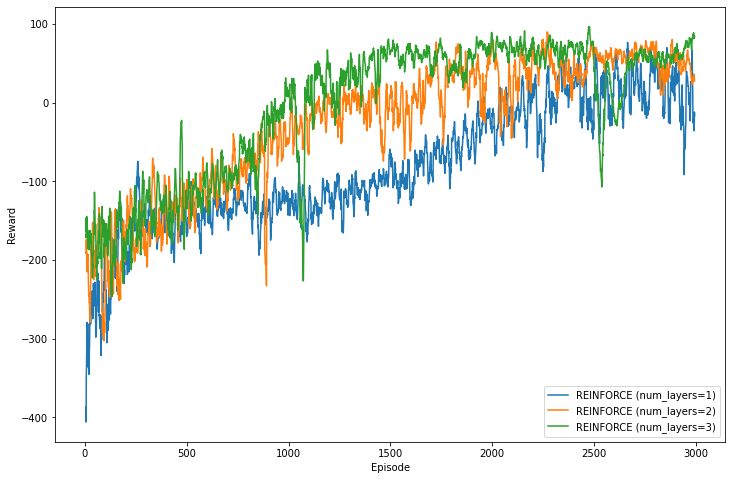

In [51]:
results = Results()
for i in range(3):
    _, _ = run_experiment(f"REINFORCE (num_layers={i+1})", discrete_env, num_episodes, policy_learning_rate=policy_lr,
                          value_learning_rate=value_lr, baseline='adaptive', num_layers=i+1)

We observe that the more layers the model has, the more the result is satisfying, meaning that we reach higher values of rewards in a smaller amount of episodes. We also notice that after 3000 iterations, there are gaps between the values that are reached. \
Knowing that the number of nodes per layer remains unchanged, we think that with less than three layers, the model cannot converge to rewards as high as those derived from the network considered above (with `num_layers=3`). Indeed, the more the model is flexible, the more the output function of the neural network will be close to the optimal action as a function of the state. \
Finally, as said in the statement, the drawback is that we use more and more computational power.